In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def generate_X(x0, y0, Vx, Vy, T, N):
    arrx = np.zeros(N)
    arry = np.zeros(N)
    arrVx = np.zeros(N)
    arrVy = np.zeros(N)
    X = np.zeros([N, 4])
    arrx[0] = x0
    arry[0] = y0
    arrVx[0] = Vx
    arrVy[0] = Vy
    for i in range(1, N):
        arrx[i] = arrx[i - 1] + arrVx[i - 1] * T
        arry[i] = arry[i - 1] + arrVy[i - 1] * T
        arrVx[i] = arrVx[i - 1]
        arrVy[i] = arrVy[i - 1]
    X[:, 0] = arrx
    X[:, 1] = arrVx
    X[:, 2] = arry
    X[:, 3] = arrVx
    return X

def generate_D(x, y):
    D = np.zeros([len(x), 2])
    for i in range(len(x)):
        D[i, 0] = (x[i] ** 2 + y[i] ** 2) ** 0.5
        D[i, 1] = np.arctan(x[i] / y[i])
    return D

def generate_eta(sigma_eta_D, sigma_eta_b, N):
    eta = np.zeros([N, 2])
    eta[:, 0] = np.random.normal(0, sigma_eta_D, N)
    eta[:, 1] = np.random.normal(0, sigma_eta_b, N)
    return eta
    
def trans_to_cart(Dm):
    Zc = np.zeros([len(Dm), 2])
    Zc[:, 0] = Dm[:, 0] * np.sin(Dm[:, 1])
    Zc[:, 1] = Dm[:, 0] * np.cos(Dm[:, 1])
    return Zc

def generate_R(Dm, sigma_eta_D, sigma_eta_b):
    R = np.zeros([len(Dm), 2, 2])
    for i in range(len(R)):
        R[i, 0, 0] = (np.sin(Dm[i, 1]) * sigma_eta_D) ** 2 + (Dm[i, 0] * np.cos(Dm[i, 1]) * sigma_eta_b) ** 2
        R[i, 0, 1] = np.sin(Dm[i, 1]) * np.cos(Dm[i, 1]) * (sigma_eta_D ** 2 - (Dm[i, 0] * sigma_eta_b) ** 2)
        R[i, 1, 0] = R[i, 0, 1]
        R[i, 1, 1] = (np.cos(Dm[i, 1]) * sigma_eta_D) ** 2 + (Dm[i, 0] * np.sin(Dm[i, 1]) * sigma_eta_b) ** 2
    return R

def kalman_filt(z, X0, P0, F, Q, R, H):
    Xii = np.zeros([len(z), len(H[0])])
    Xiin1 = np.zeros([len(z), len(H[0])])
    Piin1 = np.zeros([len(z), len(H[0]), len(H[0])])
    Pii = np.zeros([len(z), len(H[0]), len(H[0])])
    K = np.zeros([len(z), len(H[0]), len(z[0])])
    Xii[0] = X0
    Xiin1[0] = X0
    Pii[0] = P0
    Piin1[0] = P0
    for i in range(1, len(X)):
        Xiin1[i] = (F.dot(Xii[i - 1].reshape(len(H[0]), 1))).reshape(1, len(H[0]))
        Piin1[i] = (F.dot(Pii[i - 1])).dot(F.transpose()) + Q
        
        K[i] = (Piin1[i].dot(H.transpose())).dot(np.linalg.inv((H.dot(Piin1[i])).dot(H.transpose()) + R[i]))
        
        Xii[i] = Xiin1[i] + K[i].dot(z[i] - H.dot(Xiin1[i]))
        Pii[i] = (np.identity(len(H[0])) - K[i].dot(H)).dot(Piin1[i])
        
    return Xii, generate_D(Xii[:, 0], Xii[:, 2]), generate_D(Xiin1[:, 0], Xiin1[:, 2]), Pii, Piin1, K

def prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H):
    
    err_D = np.zeros([500, N - 3, 2])
    err_D_pred = np.zeros([500, N - 3, 2])
    for i in range(500):
        X = generate_X(x0, y0, Vx, Vy, T, N)
        D = generate_D(X[:, 0], X[:, 2])
        
        eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
        Dm = D + eta
        
        Zc = trans_to_cart(Dm)
        
        R = generate_R(Dm, sigma_eta_D, sigma_eta_b)
        
        X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)
        
        err_D[i, :, 0] = np.array(D[3:, 0] - X_filt[1][3:, 0]) ** 2
        err_D[i, :, 1] = np.array(D[3:, 1] - X_filt[1][3:, 1]) ** 2
        err_D_pred[i, :, 0] = np.array(D[3:, 0] - X_filt[2][3:, 0]) ** 2
        err_D_pred[i, :, 1] = np.array(D[3:, 1] - X_filt[2][3:, 1]) ** 2
        
    final_err = np.zeros([N - 3, 4])
    for i in range(N - 3):
        final_err[i] = np.array([(np.mean(err_D[:, i, 0])) ** 0.5, (np.mean(err_D[:, i, 1])) ** 0.5,
                                (np.mean(err_D_pred[:, i, 0])) ** 0.5, (np.mean(err_D_pred[:, i, 1])) ** 0.5])
    return final_err

def condition_number(Dm, sigma_eta_D, sigma_eta_b):
    cond = np.zeros(len(Dm))
    for i in range(len(Dm)):
        if sigma_eta_D ** 2 > (Dm[i, 0] * sigma_eta_b) ** 2:
            cond[i] = (sigma_eta_D ** 2) / ((Dm[i, 0] * sigma_eta_b) ** 2)
        else:
            cond[i] = ((Dm[i, 0] * sigma_eta_b) ** 2) / (sigma_eta_D ** 2)
    return cond

def generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b):
    X = generate_X(x0, y0, Vx, Vy, T, N)
    D = generate_D(X[:, 0], X[:, 2])
    sigma_eta_D, sigma_eta_b = 20, 0.02
    eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
    Dm = D + eta
    Zc = trans_to_cart(Dm)
    return Zc, Dm, generate_R(Dm, sigma_eta_D, sigma_eta_b)
    

In [3]:
# Part 1
N = 26
T = 2
Vx = -50
Vy = -45
x0 = 13500 / (2 ** 0.5)
y0 = 13500 / (2 ** 0.5)
X = generate_X(x0, y0, Vx, Vy, T, N)

In [4]:
# Part 2
D = generate_D(X[:, 0], X[:, 2])

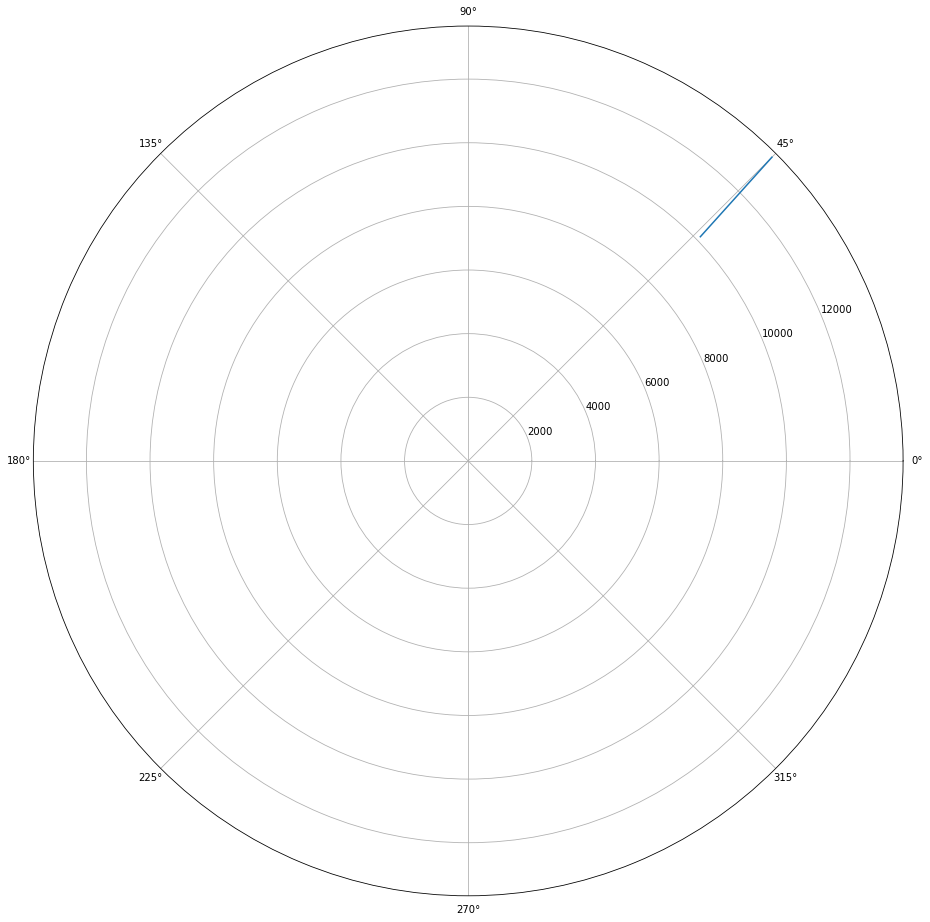

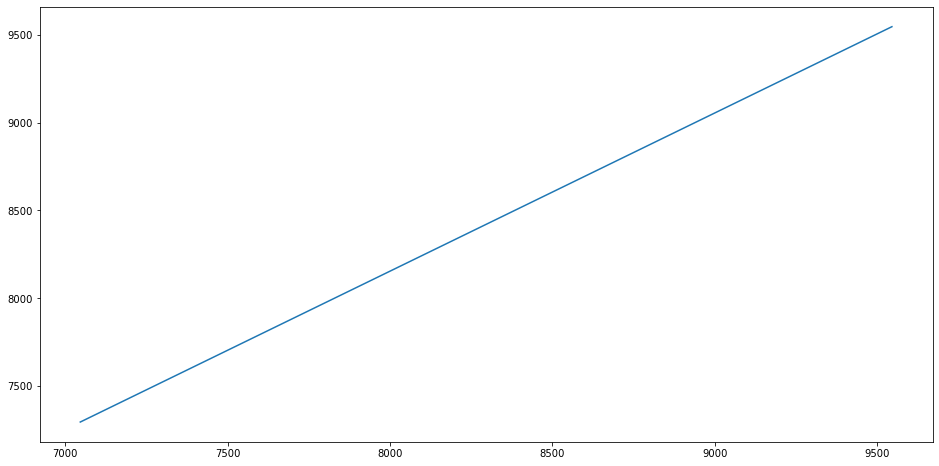

In [5]:
plt.figure(figsize = (16, 16))
plt.polar(D[:, 1], D[:, 0])
plt.show()
plt.figure(figsize = (16, 8))
plt.plot(X[:, 0], X[:, 2])

In [6]:
# Part 3
sigma_eta_D, sigma_eta_b = 20, 0.02
eta = generate_eta(sigma_eta_D, sigma_eta_b, N)
Dm = D + eta

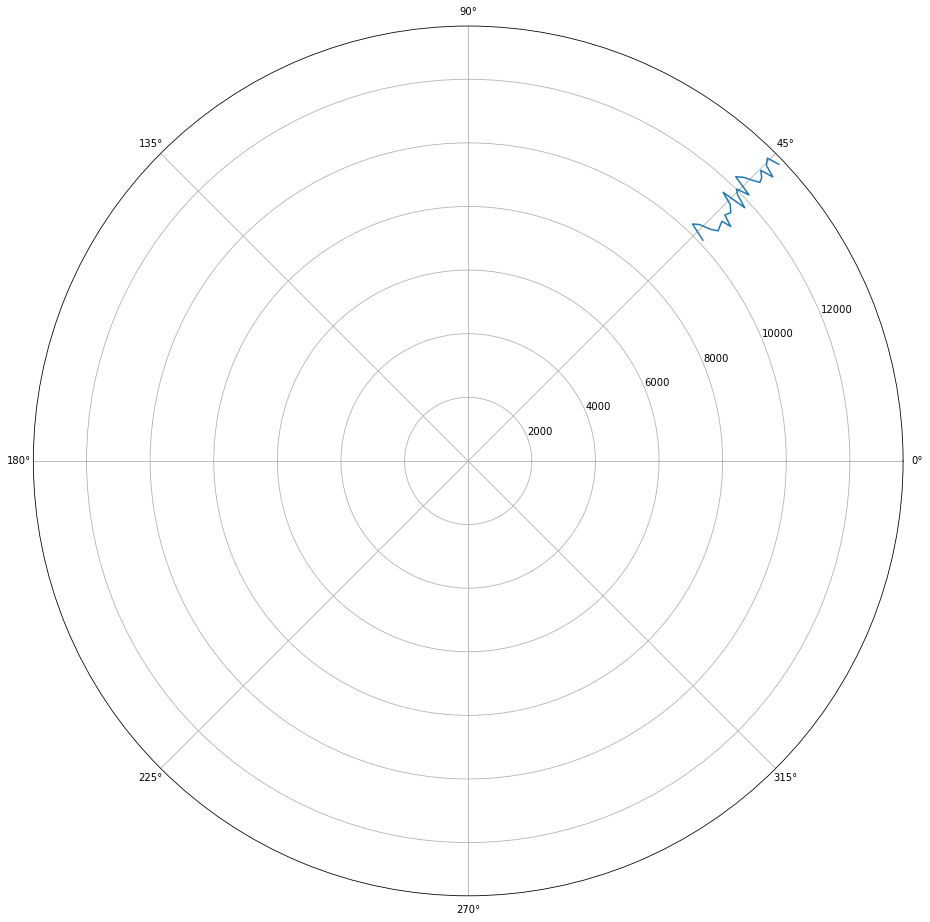

In [7]:
plt.figure(figsize = (16, 16))
plt.polar(Dm[:, 1], Dm[:, 0])

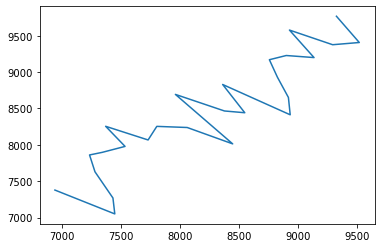

In [8]:
# Part 4 and 5
Zc = trans_to_cart(Dm)
plt.plot(Zc[:, 0], Zc[:, 1])

In [9]:
# Part 6
X0 = np.array([40000, -20, 40000, -20])
P0 = np.array([[10 ** 10, 0, 0, 0],
               [0, 10 ** 10, 0, 0],
               [0, 0, 10 ** 10, 0],
               [0, 0, 0, 10 ** 10]])

In [10]:
# Part 7
F = np.array([[1, T, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, T],
              [0, 0, 0, 1]])
H = np.array([[1, 0, 0, 0],
              [0, 0, 1, 0]])

Q = 0

In [11]:
# Part 8
R = generate_R(Dm, sigma_eta_D, sigma_eta_b)

In [12]:
X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)

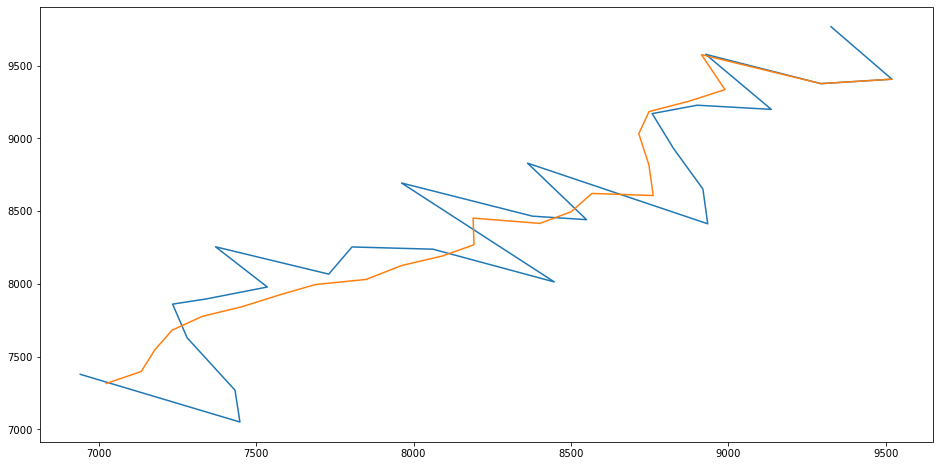

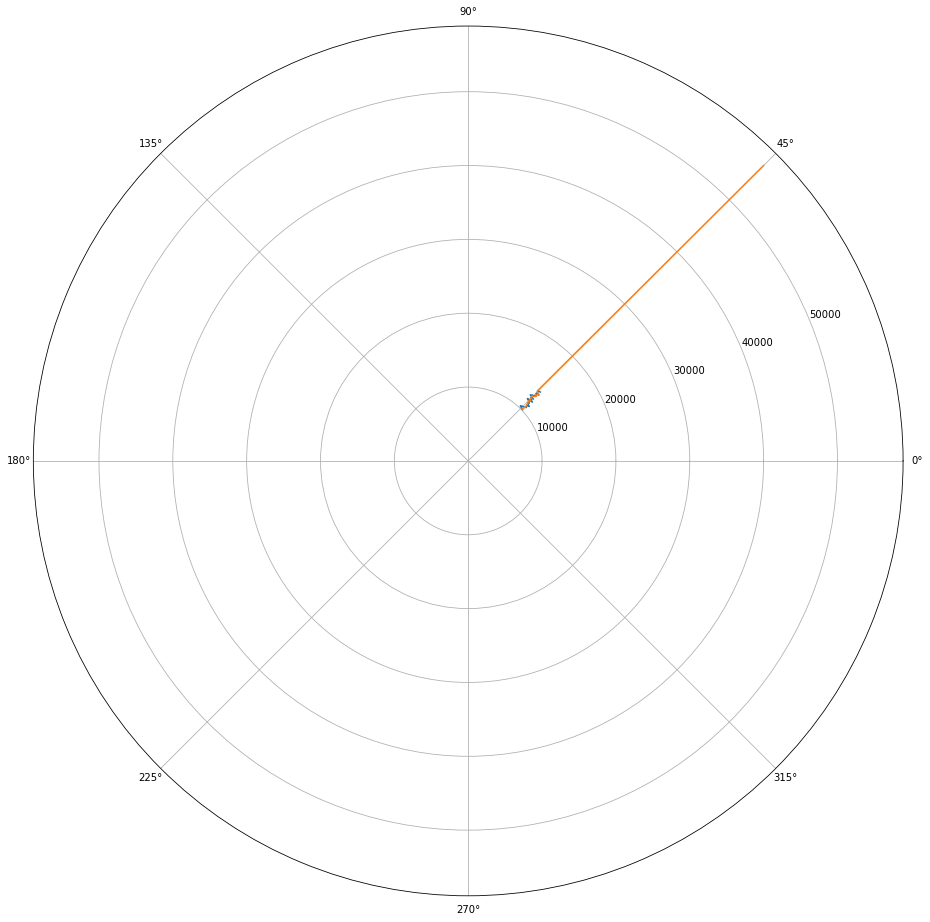

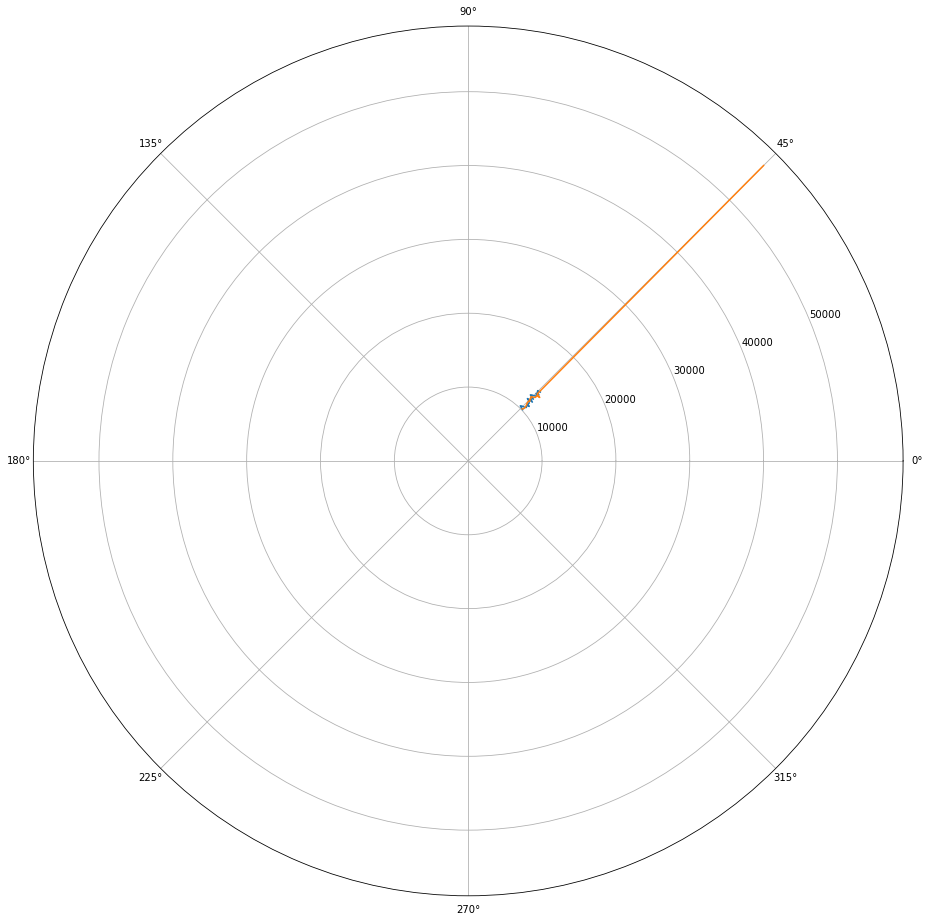

In [13]:
plt.figure(figsize = (16, 8))
plt.plot(Zc[:, 0], Zc[:, 1])
plt.plot(X_filt[0][1:, 0], X_filt[0][1:, 2])
plt.show()
plt.figure(figsize = (16, 16))
plt.polar(Dm[:, 1], Dm[:, 0])
plt.polar(X_filt[1][:, 1], X_filt[1][:, 0])
plt.figure(figsize = (16, 16))
plt.polar(Dm[:, 1], Dm[:, 0])
plt.polar(X_filt[2][:, 1], X_filt[2][:, 0])

In [14]:
# Part 9, 10
final_err = prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H)

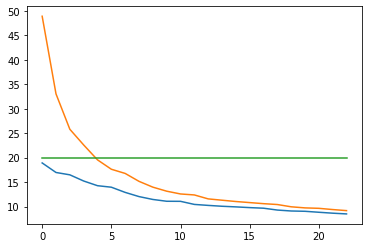

In [15]:
plt.plot(final_err[:, 0])
plt.plot(final_err[:, 2])
plt.plot(np.ones(len(final_err[:, 0])) * sigma_eta_D)

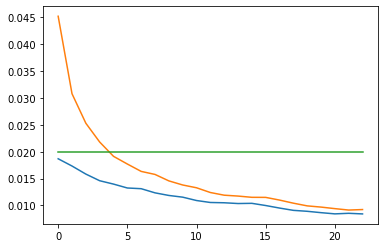

In [16]:
plt.plot(final_err[:, 1])
plt.plot(final_err[:, 3])
plt.plot(np.ones(len(final_err[:, 0])) * sigma_eta_b)

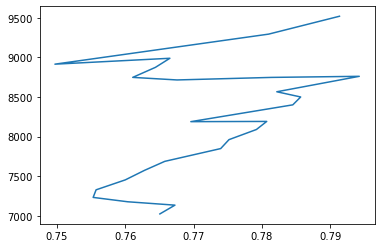

In [17]:
# Part 11
plt.plot(X_filt[1][1:,1], X_filt[0][1:, 0])

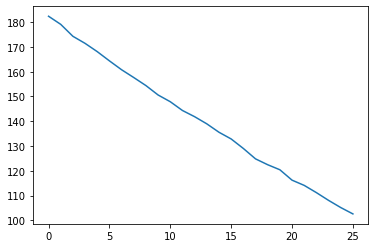

In [18]:
# Part 12
plt.plot(condition_number(Dm, sigma_eta_D, sigma_eta_b))

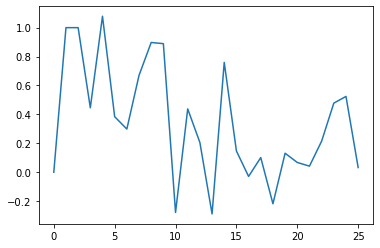

In [19]:
# Part 13
plt.plot(X_filt[-1][:, 0, 0])

In [20]:
# Part 14
x0 = 3500 / (2 ** 0.5)
y0 = 3500 / (2 ** 0.5)
Zc, Dm, R = generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b)
X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)
final_err1 = prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H)

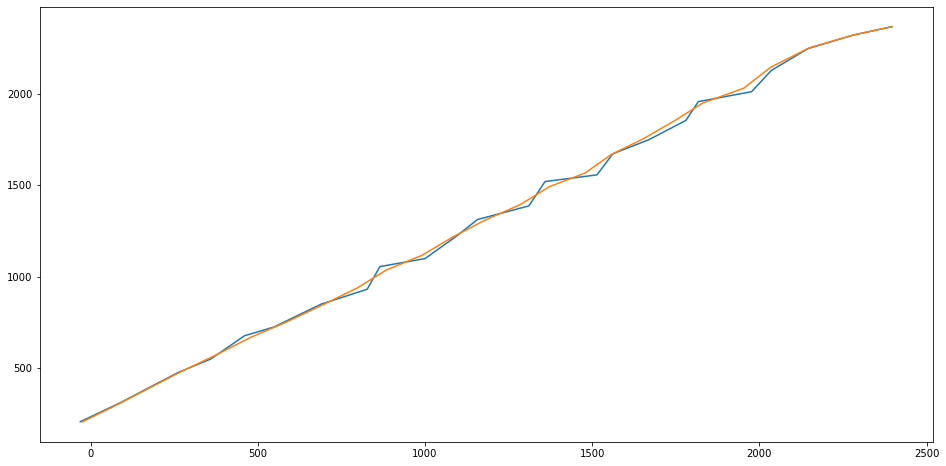

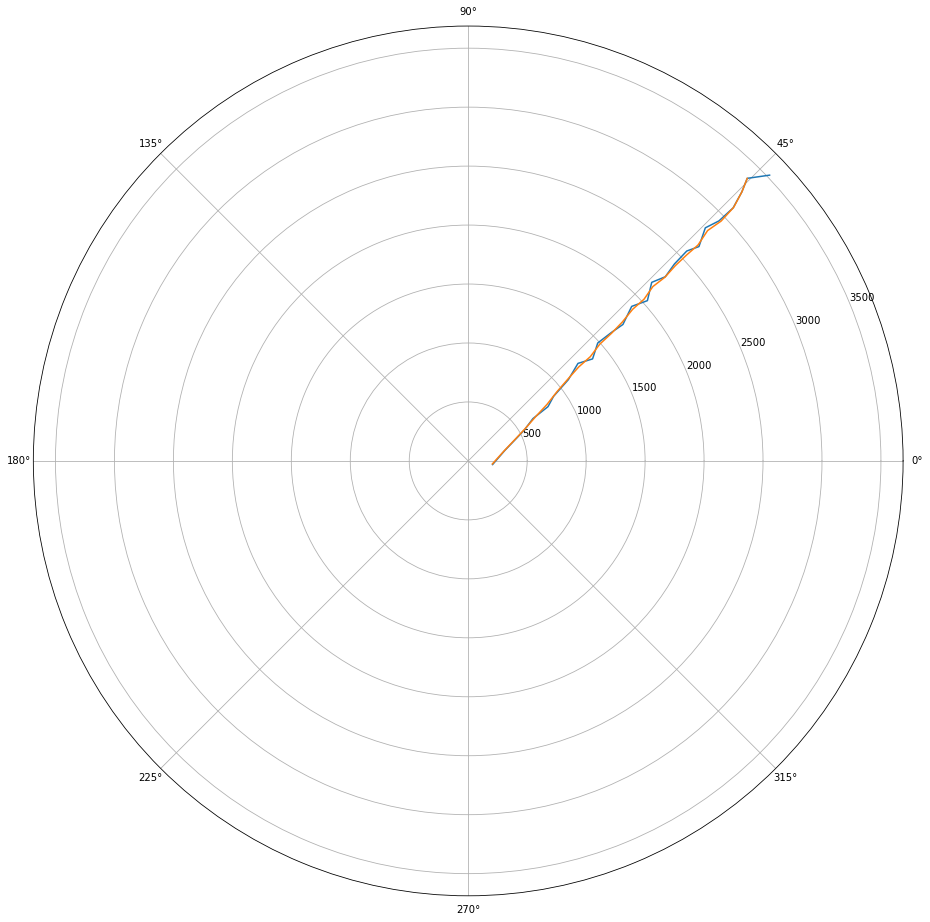

In [21]:
plt.figure(figsize = (16, 8))
plt.plot(Zc[1:, 0], Zc[1:, 1])
plt.plot(X_filt[0][1:, 0], X_filt[0][1:, 2])
plt.show()
plt.figure(figsize = (16, 16))
plt.polar(Dm[:, 1], Dm[:, 0])
plt.polar(X_filt[1][1:, 1], X_filt[1][1:, 0])

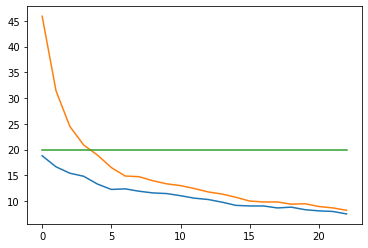

In [22]:
# Part 15
plt.plot(final_err1[:, 0])
plt.plot(final_err1[:, 2])
plt.plot(np.ones(len(final_err1[:, 0])) * sigma_eta_D)

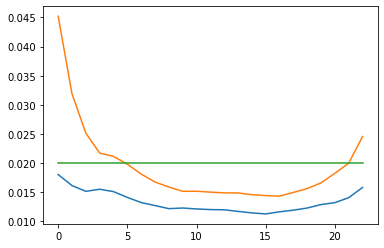

In [23]:
plt.plot(final_err1[:, 1])
plt.plot(final_err1[:, 3])
plt.plot(np.ones(len(final_err1[:, 0])) * sigma_eta_b)

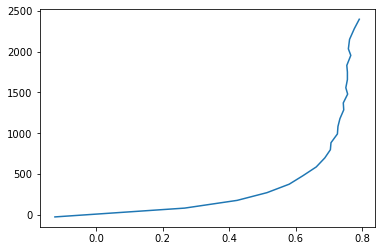

In [24]:
# Part 16
plt.plot(X_filt[1][1:,1], X_filt[0][1:, 0])

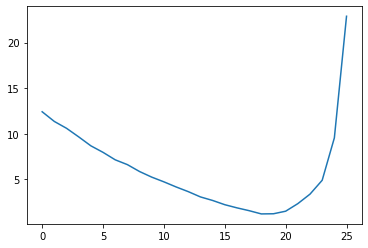

In [25]:
# Part 17
plt.plot(condition_number(Dm, sigma_eta_D, sigma_eta_b))

In [26]:
# Part 18
sigma_eta_D, sigma_eta_b = 50, 0.0015
Zc, Dm, R = generate_z(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b)
X_filt = kalman_filt(Zc, X0, P0, F, Q, R, H)
final_err2 = prob(x0, y0, Vx, Vy, T, N, sigma_eta_D, sigma_eta_b, X0, P0, F, Q, H)

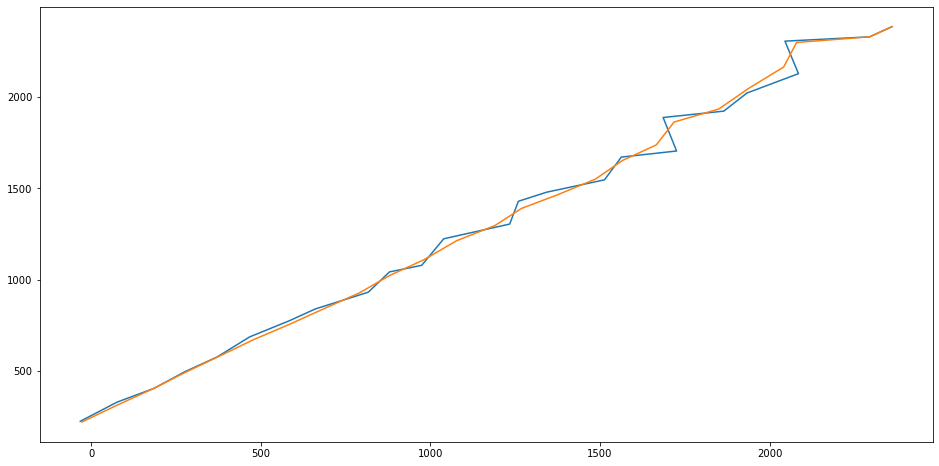

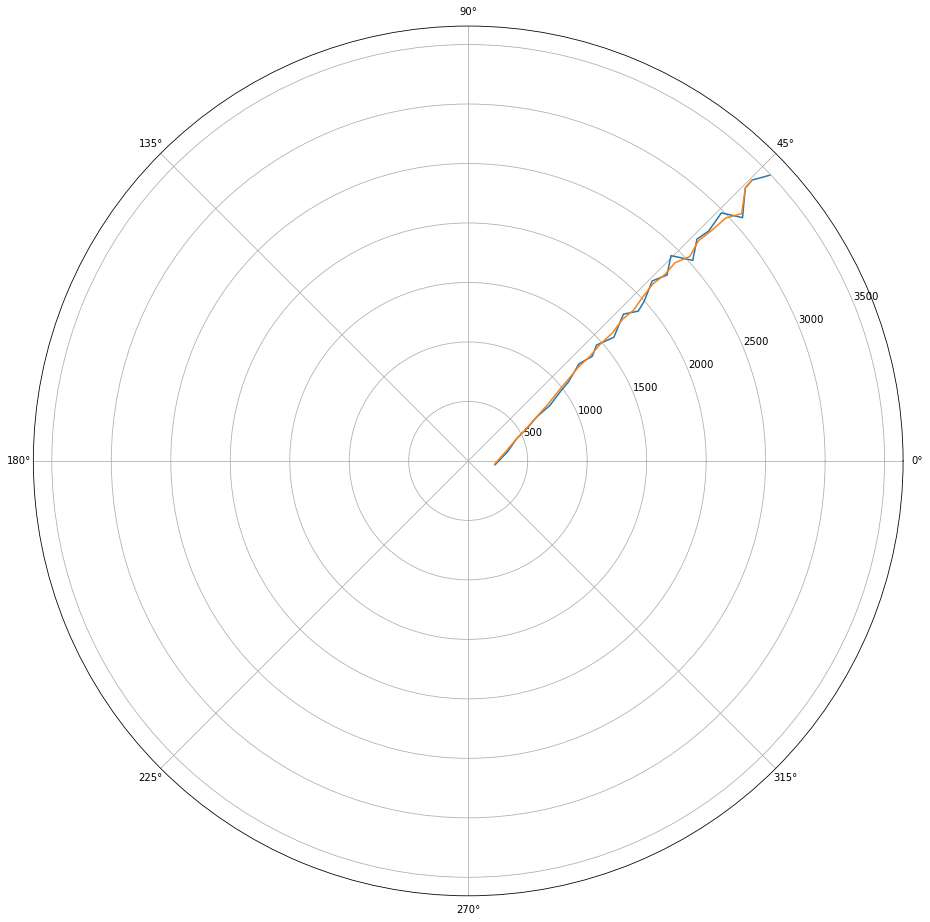

In [27]:
plt.figure(figsize = (16, 8))
plt.plot(Zc[1:, 0], Zc[1:, 1])
plt.plot(X_filt[0][1:, 0], X_filt[0][1:, 2])
plt.show()
plt.figure(figsize = (16, 16))
plt.polar(Dm[:, 1], Dm[:, 0])
plt.polar(X_filt[1][1:, 1], X_filt[1][1:, 0])

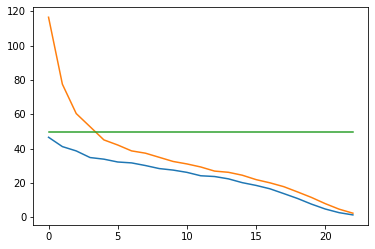

In [28]:
# Part 19
plt.plot(final_err2[:, 0])
plt.plot(final_err2[:, 2])
plt.plot(np.ones(len(final_err2[:, 0])) * sigma_eta_D)

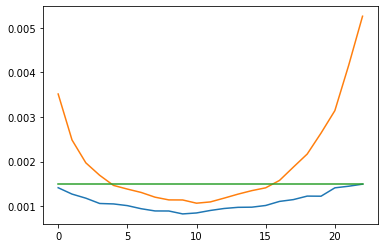

In [29]:
plt.plot(final_err2[:, 1])
plt.plot(final_err2[:, 3])
plt.plot(np.ones(len(final_err2[:, 0])) * sigma_eta_b)

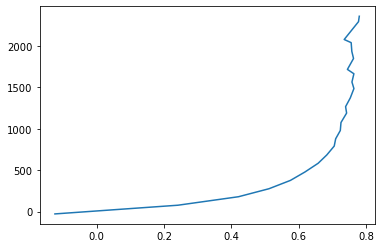

In [30]:
plt.plot(X_filt[1][1:,1], X_filt[0][1:, 0])

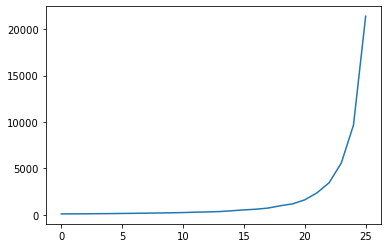

In [31]:
plt.plot(condition_number(Dm, sigma_eta_D, sigma_eta_b))